In [45]:
from importlib import reload
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
import MLP
reload(MLP)
from MLP import MLP
import MLPWrapper
reload(MLPWrapper)
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
import KAN
reload(KAN)
from KAN import KANWrapper
import KAN_model
reload(KAN_model)
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


cpu


# Prepare data

In [46]:
# get input data
datasetPath= "./datasets/uniform_sin(x)_241121"
function_folder = "uniform_sin(x)_241121"

data = CreateInput(function_folder)

tensors = data.get_tensors()
#X_train, y_train = tensors['train']

# Evaluate KAN

In [47]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors)

param_grid = {
    'kan__data': [tensors],
    'kan__width': [[1, 3, 3, 1]],
    'kan__grid': [3],
    'kan__k': [5],
    'kan__seed': [42],
    'kan__lr': [0.001],
    'kan__lamb': [0.01],
}


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=1,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)
# Fit RandomizedSearchCV
grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

# Retrieve the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_KAN = grid_search.best_params_


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/KAN/KAN.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _dataset['train_label'] = torch.tensor(y).float()
description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/KAN/KAN.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _dataset['train_label'] = torch.tensor(y).float()
description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/KAN/KAN.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

saving model version 0.1


| train_loss: 4.26e-01 | test_loss: 4.38e-01 | reg: 7.38e+00 | : 100%|█| 50/50 [00:35<00:00,  1.41it
| train_loss: 4.30e-01 | test_loss: 4.40e-01 | reg: 7.24e+00 | :  82%|▊| 41/50 [00:35<00:06,  1.34it

saving model version 0.1


| train_loss: 4.28e-01 | test_loss: 4.34e-01 | reg: 9.44e+00 | : 100%|█| 50/50 [00:36<00:00,  1.37it
| train_loss: 4.28e-01 | test_loss: 4.39e-01 | reg: 7.23e+00 | :  88%|▉| 44/50 [00:36<00:03,  1.62it

saving model version 0.1


| train_loss: 4.28e-01 | test_loss: 4.39e-01 | reg: 7.19e+00 | : 100%|█| 50/50 [00:40<00:00,  1.24it
| train_loss: 4.29e-01 | test_loss: 4.39e-01 | reg: 7.27e+00 | :  96%|▉| 48/50 [00:40<00:01,  1.41it

saving model version 0.1


| train_loss: 4.29e-01 | test_loss: 4.39e-01 | reg: 7.27e+00 | : 100%|█| 50/50 [00:41<00:00,  1.20it
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/KAN/KAN.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _dataset['train_label'] = torch.tensor(y).float()


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.30e-01 | test_loss: 4.35e-01 | reg: 6.74e+00 | : 100%|█| 50/50 [00:42<00:00,  1.18it

saving model version 0.1
Best Parameters: {'kan__width': [[1, 0], [3, 0], [3, 0], [1, 0]], 'kan__seed': 42, 'kan__lr': 0.001, 'kan__lamb': 0.01, 'kan__k': 5, 'kan__grid': 3, 'kan__data': {'train': (tensor([[ 0.8308,  0.4702],
        [-1.1912, -0.3677],
        [-0.3504,  0.1642],
        ...,
        [ 7.2172,  0.9194],
        [-1.2913, -0.0462],
        [-7.9580, -0.9745]]), tensor([ 0.7385, -0.9288, -0.3432, -0.9998, -0.6500,  0.4130,  0.1709,  0.9992,
         0.6639,  0.9760,  0.9489,  0.5734,  0.9982, -0.8482, -0.8578, -0.8022,
         0.7498, -0.1875, -0.9905,  0.5033, -0.8449, -0.6845,  0.7259,  0.5388,
        -0.6651,  0.1298,  0.0116, -0.2862, -0.8878, -0.8695, -0.8031,  0.5909,
        -0.9669,  0.5218,  0.5440,  0.5073, -0.8374,  0.8140,  0.9224,  0.6057,
        -0.4354, -0.9424, -0.2700, -0.9371, -0.8570, -0.9998,  0.8679,  0.9750,
        -0.9413,  0.5859, -0.0931,  0.9805,  0.9980, -0.7216,  0.8586, -0.8886,
         0.7529, -0.9982,  0.3258, -0.7406, -0.9992,  0.999

In [ ]:
kan_RESULTSPATH = f"./results/{function_folder}/KAN"
# evaluate KAN with optimal params
kan_model = KANModel(results_path=kan_RESULTSPATH, width=[i[0] for i in opt_params_KAN['kan__width']], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'])
kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
res = kan_model.predict()
y_preds = res['preds']
kan_test_loss = res['test_loss']
# write params to file
extra_params = {"test_loss" : kan_test_loss, "opt" : "LBFGS"}
kan_model.write_params_to_file(extra_params)

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 4.25e-01 | test_loss: 4.30e-01 | reg: 9.67e+00 | : 100%|█| 50/50 [00:37<00:00,  1.34it

saving model version 0.1
Model parameters saved to ./results/uniform_sin(x)_241121/KAN/model_params.txt


torch.Size([100, 1])


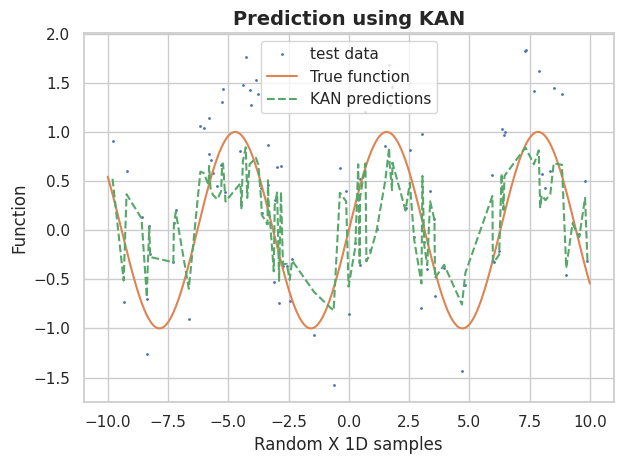

In [49]:
# plot predictions
kan_model.plot_prediction(data=tensors, y_preds=y_preds, type_='test', save=False)

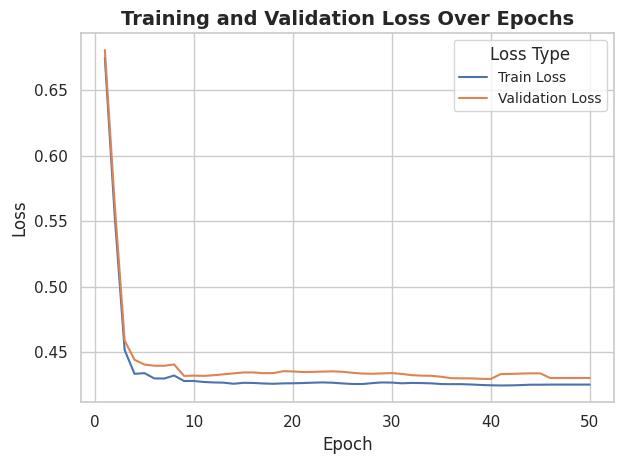

In [50]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [51]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors)

param_grid = {
    'mlp__data': [tensors],
    'mlp__input_size': [1],
    'mlp__hidden_size': [[3], [5],[5,3], [3,3,3]],
    'mlp__output_size': [1],
    'mlp__steps': [10000]
}


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=1,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/9999 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/9999 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  

Best Parameters: {'mlp__steps': 10000, 'mlp__output_size': 1, 'mlp__input_size': 1, 'mlp__hidden_size': [5], 'mlp__data': {'train': (tensor([[ 0.8308,  0.4702],
        [-1.1912, -0.3677],
        [-0.3504,  0.1642],
        ...,
        [ 7.2172,  0.9194],
        [-1.2913, -0.0462],
        [-7.9580, -0.9745]]), tensor([ 0.7385, -0.9288, -0.3432, -0.9998, -0.6500,  0.4130,  0.1709,  0.9992,
         0.6639,  0.9760,  0.9489,  0.5734,  0.9982, -0.8482, -0.8578, -0.8022,
         0.7498, -0.1875, -0.9905,  0.5033, -0.8449, -0.6845,  0.7259,  0.5388,
        -0.6651,  0.1298,  0.0116, -0.2862, -0.8878, -0.8695, -0.8031,  0.5909,
        -0.9669,  0.5218,  0.5440,  0.5073, -0.8374,  0.8140,  0.9224,  0.6057,
        -0.4354, -0.9424, -0.2700, -0.9371, -0.8570, -0.9998,  0.8679,  0.9750,
        -0.9413,  0.5859, -0.0931,  0.9805,  0.9980, -0.7216,  0.8586, -0.8886,
         0.7529, -0.9982,  0.3258, -0.7406, -0.9992,  0.9992, -0.8490, -0.8366,
        -0.4201,  0.0147, -0.7227,  0.1465, 

In [52]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'])
mlp_model.load_data(tensors)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=opt_params_MLP['mlp__steps'], cross_validation=False)
y_preds_MLP = mlp_model.predict(mlp_model.X_test)

100%|██████████| 9999/9999 [00:17<00:00, 583.19it/s]


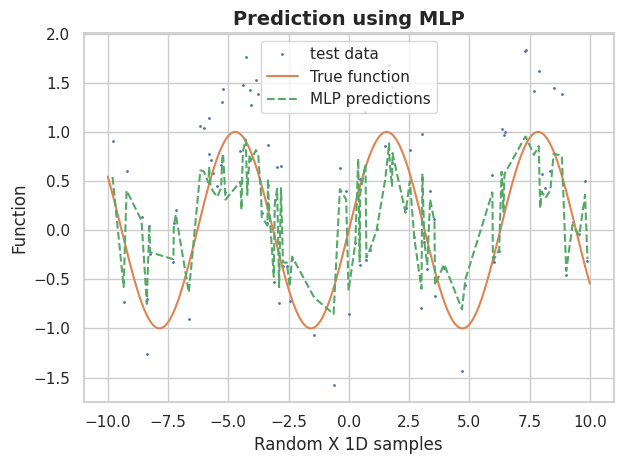

In [53]:
# plot predictions
mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP, type_='test', save=False)

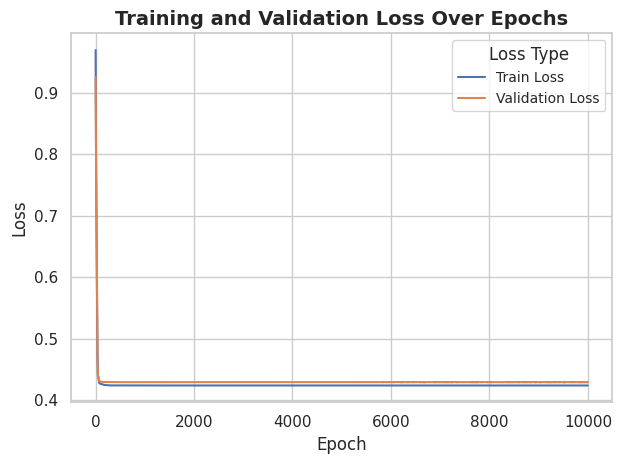

In [54]:
# plot loss
mlp_model.plot_loss(loss_data=loss_data_MLP, save=False)